# CNTL Growth Rate

## Import package

In [1]:
import sys
import numpy as np
import netCDF4 as nc
from matplotlib import pyplot as plt

sys.path.append('/home/b11209013/Package/')
import Theory as th # type: ignore
import DataProcess as dp # type: ignore
import SignalProcess as sp # type: ignore

## Functions

### Covariance

In [2]:
ft = sp.Fourier()

def Covariance(data1, data2):
    
    cs = ft.CrossSpectrum(data1, data2)

    cs_smooth = np.empty(cs.shape, dtype = complex)
    
    kernel = np.array([1, 2, 1]) / 4
    
    for i in range(cs.shape[0]):
        cs_smooth[i] = np.convolve(cs[i], kernel, mode='same')
    
    for i in range(cs.shape[1]):
        cs_smooth[:, i] = np.convolve(cs_smooth[:, i], kernel, mode='same')
    
    return cs_smooth

### Phase

In [3]:
def Phase(data1, data2):
    
    cs = np.array([
        Covariance(data1[i], data2[i])
        for i in range(data1.shape[0])
    ])
    
    phase = np.atan2(cs.imag, cs.real)
    
    return phase

### Growth Rate

In [4]:
def Growth_Rate(data1, data2):
    
    var = np.array([
        Covariance(data2[i], data2[i]).real
        for i in range(data2.shape[0])
    ]).mean(axis=0)
    cov = np.array([
        Covariance(data1[i], data2[i])
        for i in range(data2.shape[0])
    ]).mean(axis=0)
    
    sigma = 2*np.real(cov) / var
    
    return sigma

### Coherence Square

In [5]:
def Coherence(data1, data2):
    
    var1 = np.array([
        Covariance(data1[i], data1[i]).real
        for i in range(data1.shape[0])
    ]).mean(axis=0)
    var2 = np.array([
        Covariance(data2[i], data2[i]).real
        for i in range(data2.shape[0])
    ]).mean(axis=0)
    cov  = np.array([
        Covariance(data1[i], data2[i])
        for i in range(data1.shape[0])
    ]).mean(axis=0)
    
    Coh2 = ((cov.real)**2 + (cov.imag)**2) / (var1 * var2)

    return Coh2

## Load data

In [6]:
path = '/home/b11209013/2024_Research/MPAS/GrowthRate/PCA_file/'

var_list = ['tpc1', 'tpc2', 'q1pc1', 'q1pc2']


with nc.Dataset(f'{path}NSC_PC.nc','r', mmap=True) as f:
    lat  = f.variables['lat'][:]
    lon  = f.variables['lon'][:]
    time = f.variables['time'][:]

    pc_data = {
        var: f.variables[var][:] - f.variables[var][:].mean()
        for var in var_list
    }    

## Processing data

### symmetric data

In [7]:
fmt = dp.Format(lat)

ps_sym = {
    var: fmt.sym(pc_data[var])
    for var in var_list
}

### Windowing data

In [8]:
Hann_windowing = np.hanning(120)[:, None]

ps_hann = {
    var: np.array([
        ps_sym[var][i*60:i*60+120] * Hann_windowing
        for i in range(5)
        ])
    for var in var_list
}


## Compute Properties

### Phase 

In [9]:
phase = {
    'pc1': Phase(ps_hann['tpc1'], ps_hann['q1pc1']),
    'pc2': Phase(ps_hann['tpc2'], ps_hann['q1pc2'])
}

print(phase['pc1'].shape)

(5, 60, 720)


### Growth rate

In [10]:
sigma = {
    'pc1': Growth_Rate(ps_hann['q1pc1'], ps_hann['tpc1']),
    'pc2': Growth_Rate(ps_hann['q1pc2'], ps_hann['tpc2']),
}

print(sigma['pc1'].shape)

(60, 720)


### Coherence Square

In [11]:
Coh2 = {
    'pc1': Coherence(ps_hann['q1pc1'], ps_hann['tpc1']),
    'pc2': Coherence(ps_hann['q1pc2'], ps_hann['tpc2']),
}

## Plot out the figure

In [12]:
wn = np.linspace(-360, 360, 720)
fr = np.linspace(1/30, 2, 60)

wnm, frm = np.meshgrid(wn, fr)

### Growth Rate

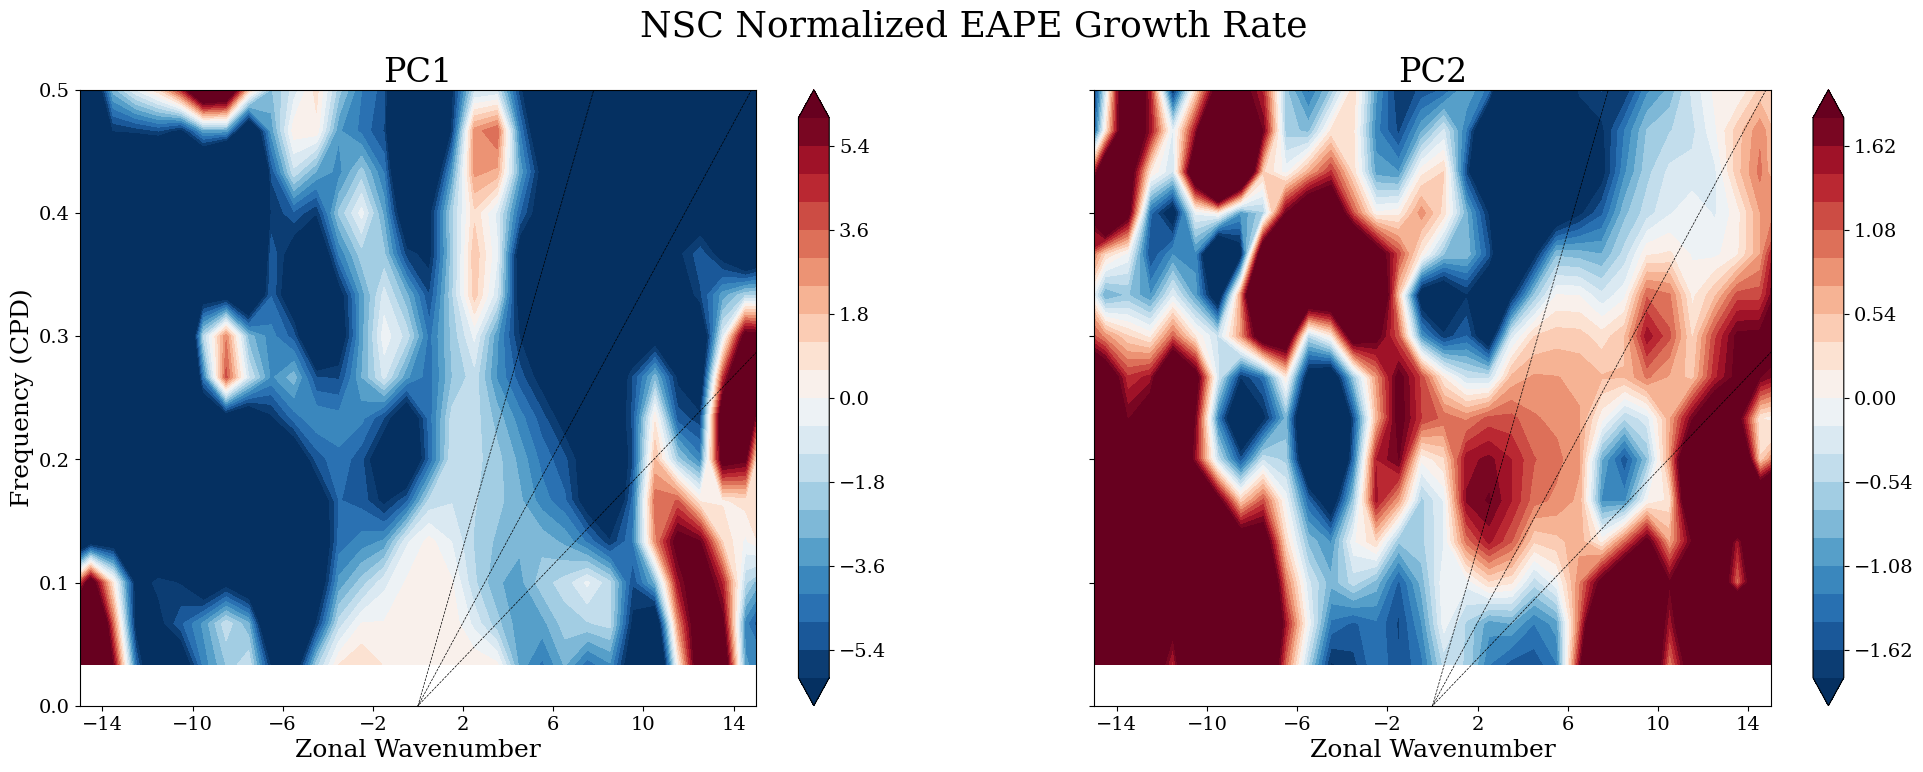

In [13]:
fr_ana, wn_ana = th.genDispersionCurves(Ahe=[90, 25, 8])

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'figure.titlesize': 26,
    'axes.labelsize': 18,
    'axes.titlesize': 24,
})

fig, ax = plt.subplots(1, 2, figsize=(24, 8), sharey=True)
c1 = ax[0].contourf(wnm, frm, sigma['pc1'], levels=np.linspace(-6, 6, 21), cmap='RdBu_r', extend='both')
ax[0].plot(wn_ana[4, 0, :], fr_ana[4, 0, :], 'k', linewidth=0.5, linestyle='--')
ax[0].plot(wn_ana[4, 1, :], fr_ana[4, 1, :], 'k', linewidth=0.5, linestyle='--')
ax[0].plot(wn_ana[4, 2, :], fr_ana[4, 2, :], 'k', linewidth=0.5, linestyle='--')
ax[0].set_xticks(np.linspace(-14, 14, 8))
ax[0].set_yticks(np.linspace(0, 0.5, 6))
ax[0].set_xlim(-15, 15)
ax[0].set_ylim(0, 1/2)
ax[0].set_xlabel('Zonal Wavenumber')
ax[0].set_ylabel('Frequency (CPD)')
ax[0].set_title('PC1')
plt.colorbar(c1, ax=ax[0])

c2 = ax[1].contourf(wnm, frm, sigma['pc2'], levels=np.linspace(-1.8, 1.8, 21), cmap='RdBu_r', extend='both')
ax[1].plot(wn_ana[4, 0, :], fr_ana[4, 0, :], 'k', linewidth=0.5, linestyle='--')
ax[1].plot(wn_ana[4, 1, :], fr_ana[4, 1, :], 'k', linewidth=0.5, linestyle='--')
ax[1].plot(wn_ana[4, 2, :], fr_ana[4, 2, :], 'k', linewidth=0.5, linestyle='--')
ax[1].set_xticks(np.linspace(-14, 14, 8))
ax[1].set_xlim(-15, 15)
ax[1].set_ylim(0, 1/2)
ax[1].set_xlabel('Zonal Wavenumber')
ax[1].set_title('PC2')
plt.colorbar(c2, ax=ax[1])

plt.suptitle('NSC Normalized EAPE Growth Rate ')

plt.savefig('/home/b11209013/2024_Research/MPAS/GrowthRate/image/NSC_gr.png', dpi=600)

plt.show()


## Fish's z-transform

### Functions

In [14]:
def fisher_z(Coh2):
    r = np.sqrt(Coh2)
    z = 0.5 * np.log((1+r)/(1-r))    
    return z

In [15]:
Z_f = {
    'pc1': fisher_z(Coh2['pc1']),
    'pc2': fisher_z(Coh2['pc2']),
}

### Find Confidence levels of the transformed-z

In [16]:
CL99_1 = Z_f['pc1'].mean() + 1.64 * Z_f['pc1'].std()
CL99_2 = Z_f['pc2'].mean() + 1.64 * Z_f['pc2'].std()

### Coh2 

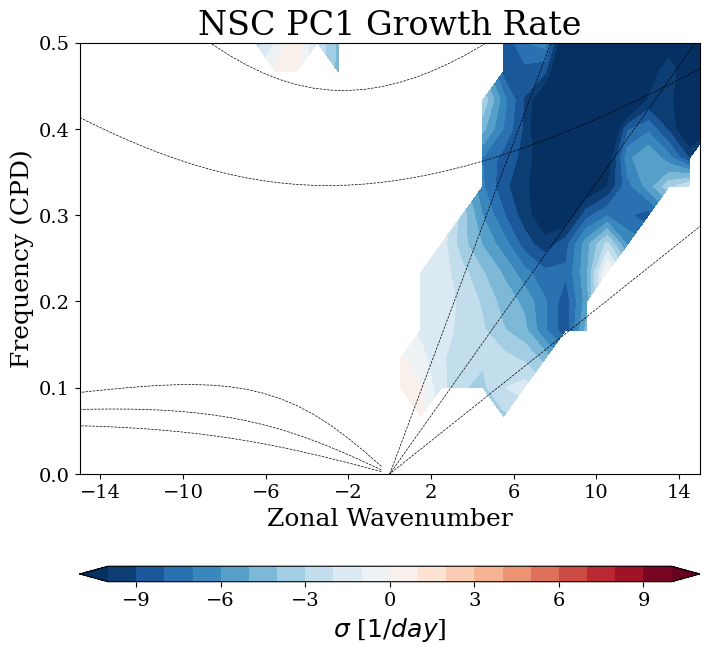

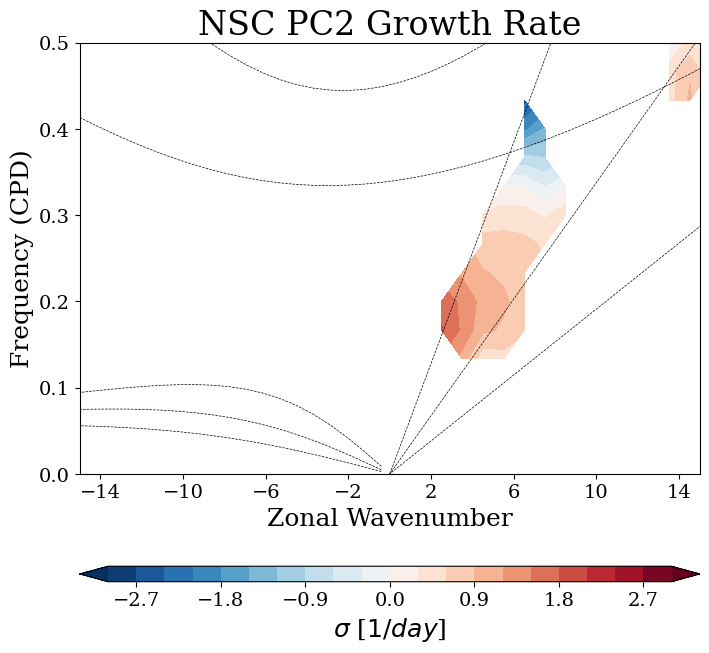

In [17]:
Coh2_pc1_filted = np.where(Z_f['pc1'] > CL99_1, sigma['pc1'], np.nan)
Coh2_pc2_filted = np.where(Z_f['pc2'] > CL99_2, sigma['pc2'], np.nan)

e_cond = np.where(wn_ana[3, 0, :] <0)[0]

fig= plt.figure(figsize=(8, 8))
c1 = plt.contourf(wnm, frm, Coh2_pc1_filted, levels=np.linspace(-10, 10, 21), cmap='RdBu_r', extend='both')
plt.plot(wn_ana[3, 0, :][e_cond], fr_ana[3, 0, :][e_cond], 'k', linewidth=0.5, linestyle='--')
plt.plot(wn_ana[3, 1, :][e_cond], fr_ana[3, 1, :][e_cond], 'k', linewidth=0.5, linestyle='--')
plt.plot(wn_ana[3, 2, :][e_cond], fr_ana[3, 2, :][e_cond], 'k', linewidth=0.5, linestyle='--')
plt.plot(wn_ana[4, 0, :], fr_ana[4, 0, :], 'k', linewidth=0.5, linestyle='--')
plt.plot(wn_ana[4, 1, :], fr_ana[4, 1, :], 'k', linewidth=0.5, linestyle='--')
plt.plot(wn_ana[4, 2, :], fr_ana[4, 2, :], 'k', linewidth=0.5, linestyle='--')
plt.plot(wn_ana[5, 0, :], fr_ana[5, 0, :], 'k', linewidth=0.5, linestyle='--')
plt.plot(wn_ana[5, 1, :], fr_ana[5, 1, :], 'k', linewidth=0.5, linestyle='--')
plt.plot(wn_ana[5, 2, :], fr_ana[5, 2, :], 'k', linewidth=0.5, linestyle='--')
plt.xticks(np.linspace(-14, 14, 8))
plt.yticks(np.linspace(0, 0.5, 6))
plt.xlim(-15, 15)
plt.ylim(0, 1/2)
plt.xlabel('Zonal Wavenumber')
plt.ylabel('Frequency (CPD)')
plt.title('NSC PC1 Growth Rate')
plt.colorbar(c1, label=r'$\sigma$ [$1/day$]', orientation='horizontal', aspect=40)

plt.savefig('/home/b11209013/2024_Research/MPAS/GrowthRate/image/NSC_pc1_gr_filted.png', dpi=600)
plt.show()

fig= plt.figure(figsize=(8, 8))
c2 = plt.contourf(wnm, frm, Coh2_pc2_filted, levels=np.linspace(-3, 3, 21), cmap='RdBu_r', extend='both')
plt.plot(wn_ana[3, 0, :][e_cond], fr_ana[3, 0, :][e_cond], 'k', linewidth=0.5, linestyle='--')
plt.plot(wn_ana[3, 1, :][e_cond], fr_ana[3, 1, :][e_cond], 'k', linewidth=0.5, linestyle='--')
plt.plot(wn_ana[3, 2, :][e_cond], fr_ana[3, 2, :][e_cond], 'k', linewidth=0.5, linestyle='--')
plt.plot(wn_ana[4, 0, :], fr_ana[4, 0, :], 'k', linewidth=0.5, linestyle='--')
plt.plot(wn_ana[4, 1, :], fr_ana[4, 1, :], 'k', linewidth=0.5, linestyle='--')
plt.plot(wn_ana[4, 2, :], fr_ana[4, 2, :], 'k', linewidth=0.5, linestyle='--')
plt.plot(wn_ana[5, 0, :], fr_ana[5, 0, :], 'k', linewidth=0.5, linestyle='--')
plt.plot(wn_ana[5, 1, :], fr_ana[5, 1, :], 'k', linewidth=0.5, linestyle='--')
plt.plot(wn_ana[5, 2, :], fr_ana[5, 2, :], 'k', linewidth=0.5, linestyle='--')
plt.xticks(np.linspace(-14, 14, 8))
plt.yticks(np.linspace(0, 0.5, 6))
plt.xlim(-15, 15)
plt.ylim(0, 1/2)
plt.xlabel('Zonal Wavenumber')
plt.ylabel('Frequency (CPD)')
plt.title('NSC PC2 Growth Rate')
plt.colorbar(c2, label=r'$\sigma$ [$1/day$]', orientation='horizontal', aspect=40)

plt.savefig('/home/b11209013/2024_Research/MPAS/GrowthRate/image/NSC_pc2_gr_filted.png', dpi=600)

plt.show()
